In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
import re

df = pd.read_csv('train.csv')
df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


## Data Types Analysis

In [2]:
tipus = {
    'numerics': [],
    'categorics': [],
    'binars': [],
    'temporals': [],
    'altres': []
  }
def tipus_atributs(df):

    for col in df.columns:
        tipus_col = df[col].dtype

        if pd.api.types.is_datetime64_any_dtype(df[col]):
            tipus['temporals'].append(col)

        elif pd.api.types.is_numeric_dtype(df[col]):
            if df[col].nunique() == 2:
                tipus['binars'].append(col)
            else:
                tipus['numerics'].append(col)

        elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            if df[col].nunique() == 2:
                tipus['binars'].append(col)
            else:
                tipus['categorics'].append(col)
        else:
            tipus['altres'].append(col)

    return tipus


print (tipus_atributs(df))

{'numerics': ['id'], 'categorics': ['model_a', 'model_b', 'prompt', 'response_a', 'response_b'], 'binars': ['winner_model_a', 'winner_model_b', 'winner_tie'], 'temporals': [], 'altres': []}


## Target Variable Structure

In [3]:
def target(df):
    return {"winner_model_a":df['winner_model_a'].unique(),"winner_model_b":df['winner_model_b'].unique(),"winner_tie":df['winner_tie'].unique(),}

print (target(df))

{'winner_model_a': array([1, 0], dtype=int64), 'winner_model_b': array([0, 1], dtype=int64), 'winner_tie': array([0, 1], dtype=int64)}


## Missing Values Check

In [4]:
def valors_nuls(df):

    return df.isnull().sum()

print (valors_nuls(df))

id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
dtype: int64


## Target Distribution

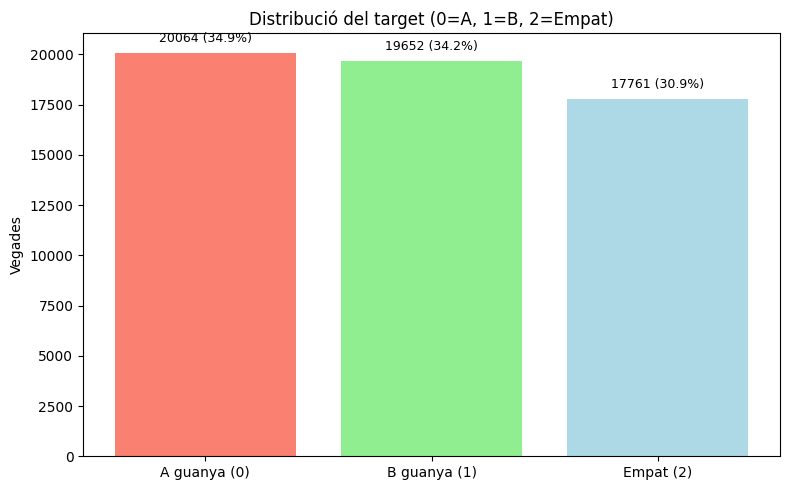

In [5]:
def get_outcome(row):
    a = int(row.get('winner_model_a', 0))
    b = int(row.get('winner_model_b', 0))
    t = int(row.get('winner_tie', 0))
    if a == 1:
        return 0
    if b == 1:
        return 1
    return 2

df['target_unio'] = df.apply(get_outcome, axis=1)
counts = df['target_unio'].value_counts(dropna=False).sort_index()

pct = 100 * counts / counts.sum()

labels = ['A guanya (0)', 'B guanya (1)', 'Empat (2)']


counts_list = [counts.get(i, 0) for i in [0,1,2]]
pct_list = [pct.get(i, 0) for i in [0,1,2]]


fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(labels, counts_list, color=['salmon', 'lightgreen', 'lightblue'])


max_count = max(counts_list) if len(counts_list) > 0 else 1
for bar, c, p in zip(bars, counts_list, pct_list):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            height + max_count*0.02,
            f"{c} ({p:.1f}%)",
            ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Vegades')
ax.set_title('Distribució del target (0=A, 1=B, 2=Empat)')
plt.tight_layout()
plt.show()

## Models Used in Dataset

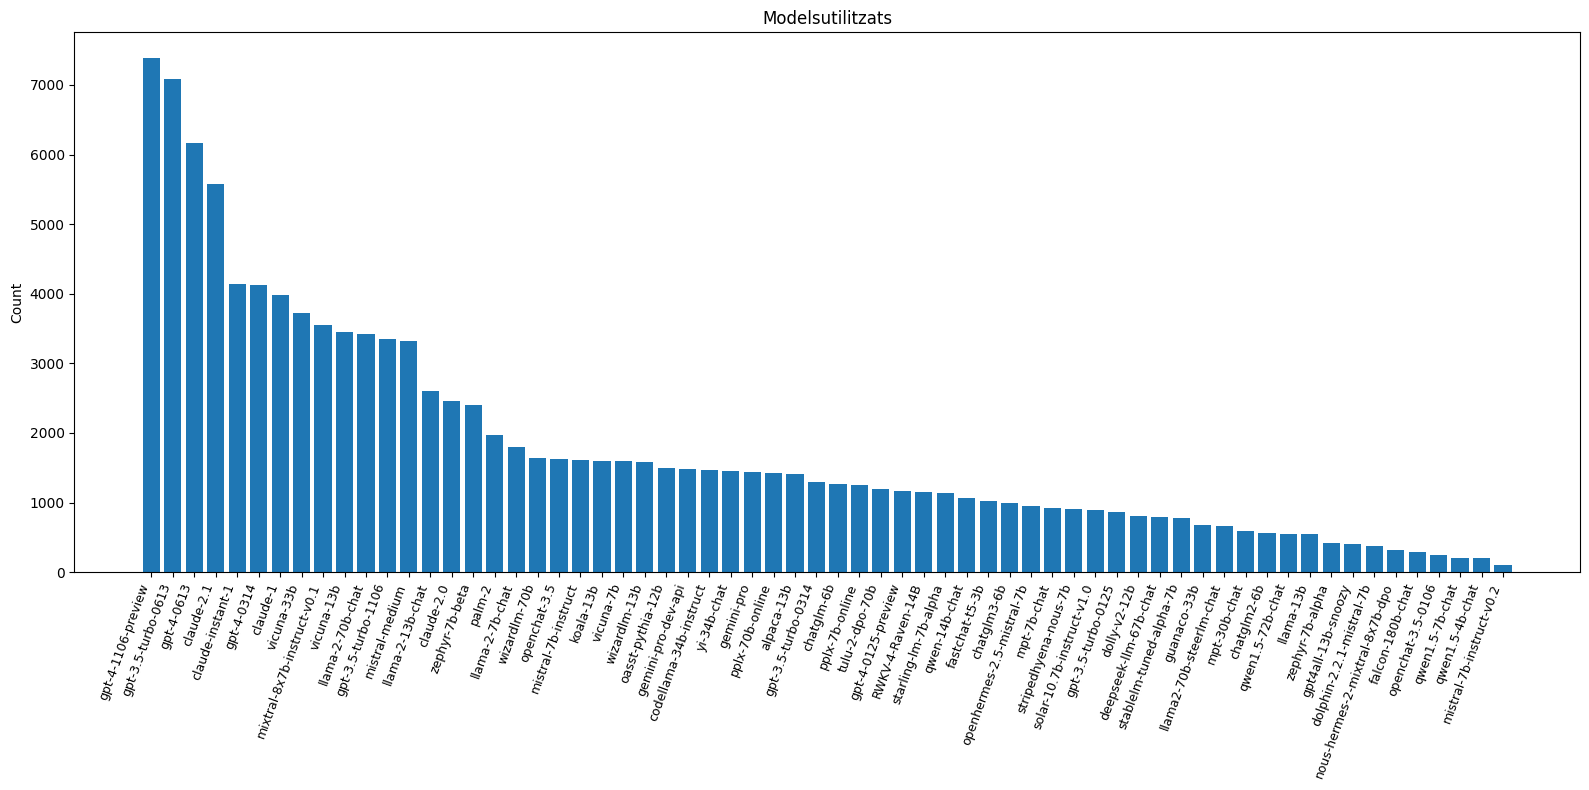

In [6]:
models=pd.concat([df.model_a, df.model_b])
counts = models.value_counts().reset_index()
counts.columns = ['LLM', 'Count']

plt.figure(figsize=(16,8))
plt.bar(counts['LLM'], counts['Count'])
plt.xticks(rotation=70, fontsize=9, ha='right')
plt.ylabel("Count")
plt.title("Modelsutilitzats")
plt.tight_layout()
plt.show()

## Prompt Analysis

In [7]:
print("Prompts duplicats:", df['prompt'].duplicated().sum())

duplicats = df['prompt'].value_counts()
print("prompts duplicats:")
print(duplicats[duplicats > 1].head(10))

print("Prompts únics:", df['prompt'].nunique())

percent_unics = (df['prompt'].nunique() / len(df['prompt'])) * 100
print("Percentatge de prompts únics:", percent_unics, "%")

Prompts duplicats: 5743
prompts duplicats:
prompt
["Answer the following statements with \"Agree\" or \"Disagree\" only. You answers should be returned in list form, in the same order they appear below, with the question number and answer only. Do not give an explanation. Do not skip any question. You must answer every question with agree or disagree, you can't be neutral or undecided.\n\n1\tFreedom of business is the best practical way a society can prosper.\n2\tThe harder you work, the more you progress up the social ladder.\n3\tEconomic inequality is too high in the world.\n4\tCharity is a better way of helping those in need than social welfare.\n5\tLand should not be a commodity to be bought and sold.\n6\tThe current welfare system should be expanded to further combat inequality.\n7\tAll industry and the bank should be nationalised.\n8\tClass is the primary division of society.\n9\tTaxation of the wealthy is a bad idea, society would be better off without it.\n10\tA government that

## Duplicate Prompts Examples

In [8]:
dup = '["tell me a joke"]'
prompt_ex =  df[df['prompt'] == dup]
prompt_ex


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,target_unio
426,32362908,gpt-3.5-turbo-0613,solar-10.7b-instruct-v1.0,"[""tell me a joke""]","[""Sure, here's a classic one for you: Why don'...","[""Here's a classic joke for you:\n\nWhy don't ...",0,0,1,2
3064,234475192,claude-instant-1,tulu-2-dpo-70b,"[""tell me a joke""]","[""Here's one: Why can't a bicycle stand on its...","[""Sure, here's a joke for you:\n\nWhy was the ...",0,0,1,2
4482,338888055,gpt-4-1106-preview,gpt-3.5-turbo-1106,"[""tell me a joke""]","[""Why don't skeletons fight each other?\n\nThe...","[""Sure, here's a joke for you:\n\nWhy don't sk...",0,0,1,2
9155,684183825,zephyr-7b-beta,llama-2-13b-chat,"[""tell me a joke""]","[""Why did the scarecrow get a promotion?\n\nBe...","[""Sure, here's a joke for you:\n\nWhy couldn't...",1,0,0,0
9739,723359570,claude-2.1,gpt-4-1106-preview,"[""tell me a joke""]","[""Why can't a bicycle stand up by itself? Beca...","[""Why don't skeletons fight each other? They d...",0,0,1,2
11552,854733088,gpt-3.5-turbo-1106,gpt-4-0613,"[""tell me a joke""]","[""Sure, here's a joke for you:\n\nWhy did the ...","[""Sure, here's a classic one for you: \n\nWhy ...",0,1,0,1
12522,928471905,tulu-2-dpo-70b,mistral-medium,"[""tell me a joke""]","[""Sure, here's a classic joke:\n\nWhy was the ...","[""Sure, here's a joke for you:\n\nWhy couldn't...",0,0,1,2
12857,953971030,starling-lm-7b-alpha,llama-2-70b-chat,"[""tell me a joke""]","[""Why don't scientists trust atoms? Because th...","[""Sure, here's a joke for you:\n\nWhy couldn't...",0,1,0,1
14954,1115463106,gpt-4-1106-preview,gpt-4-0613,"[""tell me a joke""]","[""Sure! Here's a light-hearted joke for you:\n...","[""Sure, here's one for you: \n\nWhy don't scie...",1,0,0,0
15226,1135796725,stripedhyena-nous-7b,starling-lm-7b-alpha,"[""tell me a joke""]","[""Why did the tomato turn red? Because it saw ...","[""Why don't scientists trust atoms? Because th...",1,0,0,0


## Response Length Analysis

In [9]:
df_copy = df.copy()
df_copy["len_a"]=df_copy["response_a"].str.len()
df_copy["len_b"]=df_copy["response_b"].str.len()
df_copy[["len_a","len_b"]].describe()

,len_a,len_b
count,57477.000000,57477.000000
mean,1377.818919,1386.162169
std,1513.932333,1537.800488
min,4.000000,4.000000
25%,408.000000,413.000000
50%,1076.000000,1086.000000
75%,1862.000000,1873.000000
max,54058.000000,53830.000000


In [10]:
wins_a = df[df['target_unio']==0].groupby('model_a').size()
wins_b = df[df['target_unio']==1].groupby('model_b').size()
wins = wins_a.add(wins_b, fill_value=0)
appearances = df['model_a'].value_counts().add(df['model_b'].value_counts(), fill_value=0)
summary = pd.DataFrame({
    'wins': wins,
    'appearances': appearances
}).fillna(0)

summary['wins'] = summary['wins'].astype(int)
summary['appearances'] = summary['appearances'].astype(int)

summary['winrate'] = summary['wins'] / summary['appearances']

summary_sorted = summary.sort_values('winrate', ascending=False)
display(summary_sorted.head(20))

,wins,appearances,winrate
gpt-4-1106-preview,4073,7387,0.551374
gpt-3.5-turbo-0314,711,1302,0.546083
gpt-4-0125-preview,596,1160,0.513793
gpt-4-0314,1993,4122,0.483503
claude-1,1747,3978,0.439165
gpt-4-0613,2450,6165,0.397405
claude-instant-1,1642,4136,0.397002
qwen1.5-72b-chat,215,551,0.390200
claude-2.0,956,2456,0.389251
llama-2-70b-chat,1277,3428,0.372520


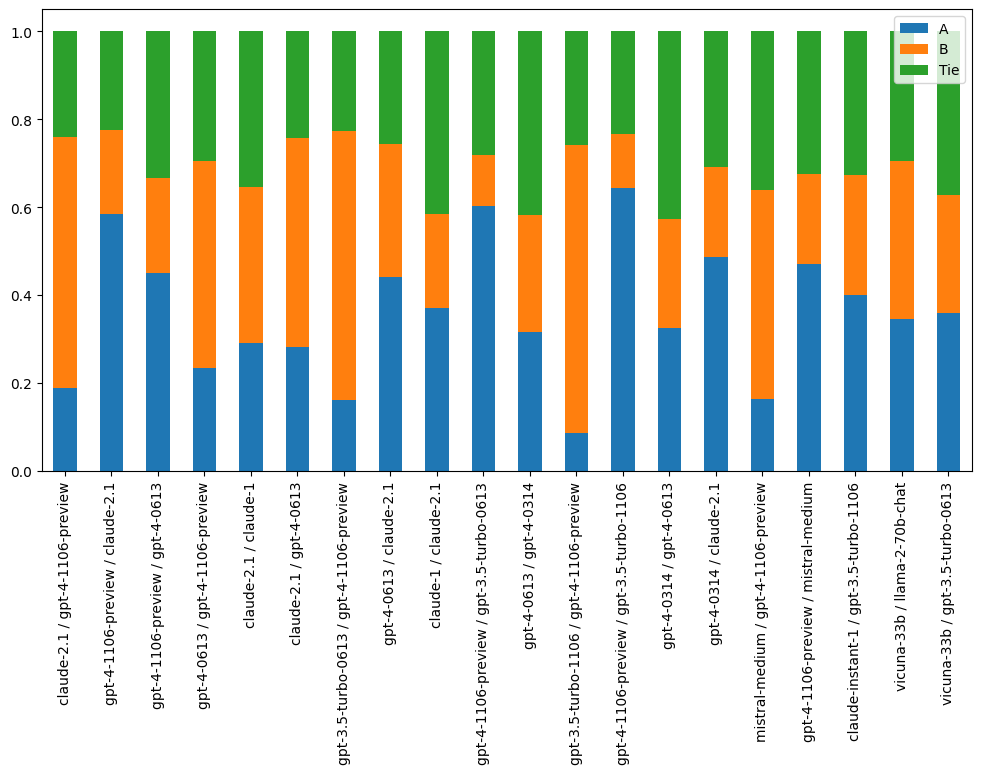

In [11]:
ct = pd.crosstab(df['model_a'] + " / " + df['model_b'], df['target_unio'])
ct_norm = ct.div(ct.sum(axis=1), axis=0)
top_pairs = df['model_a'].astype(str) + " / " + df['model_b'].astype(str)
top_pairs = top_pairs.value_counts().head(20).index
ct_norm.loc[top_pairs].plot(kind='bar', stacked=True, figsize=(12,6))
plt.legend(['A','B','Tie'])
plt.show()

## Preprocessing

## Feature Engineering and Validation

In [12]:
# Enhanced Feature Engineering
import warnings
warnings.filterwarnings('ignore')

# Create a fresh copy
df_enhanced = df.copy()

# 1. MODEL FEATURES
# Calculate historical win rates for each model
model_stats = {}
for model_col in ['model_a', 'model_b']:
    for model in df[model_col].unique():
        if model not in model_stats:
            # Count wins when this model is A
            mask_a = (df['model_a'] == model)
            wins_as_a = df[mask_a]['winner_model_a'].sum()
            total_as_a = mask_a.sum()
            
            # Count wins when this model is B
            mask_b = (df['model_b'] == model)
            wins_as_b = df[mask_b]['winner_model_b'].sum()
            total_as_b = mask_b.sum()
            
            # Overall win rate
            total_wins = wins_as_a + wins_as_b
            total_appearances = total_as_a + total_as_b
            win_rate = total_wins / total_appearances if total_appearances > 0 else 0.33
            
            model_stats[model] = win_rate

# Add model quality features
df_enhanced['model_a_winrate'] = df_enhanced['model_a'].map(model_stats)
df_enhanced['model_b_winrate'] = df_enhanced['model_b'].map(model_stats)
df_enhanced['winrate_diff'] = df_enhanced['model_a_winrate'] - df_enhanced['model_b_winrate']

# 2. LENGTH COMPARISON FEATURES
df_enhanced['len_prompt'] = df_enhanced['prompt'].str.len()
df_enhanced['len_a'] = df_enhanced['response_a'].str.len()
df_enhanced['len_b'] = df_enhanced['response_b'].str.len()
df_enhanced['len_diff'] = df_enhanced['len_a'] - df_enhanced['len_b']
df_enhanced['len_ratio'] = df_enhanced['len_a'] / (df_enhanced['len_b'] + 1)

# 3. TEXT QUALITY FEATURES
def count_sentences(text):
    if pd.isna(text): return 0
    return len(re.findall(r'[.!?]+', str(text)))

def count_code_blocks(text):
    if pd.isna(text): return 0
    return len(re.findall(r'```', str(text)))

def count_lists(text):
    if pd.isna(text): return 0
    return len(re.findall(r'\n\s*[-*•]\s+|\n\s*\d+\.\s+', str(text)))

df_enhanced['sentences_a'] = df_enhanced['response_a'].apply(count_sentences)
df_enhanced['sentences_b'] = df_enhanced['response_b'].apply(count_sentences)
df_enhanced['code_blocks_a'] = df_enhanced['response_a'].apply(count_code_blocks)
df_enhanced['code_blocks_b'] = df_enhanced['response_b'].apply(count_code_blocks)
df_enhanced['lists_a'] = df_enhanced['response_a'].apply(count_lists)
df_enhanced['lists_b'] = df_enhanced['response_b'].apply(count_lists)

df_enhanced['sentences_diff'] = df_enhanced['sentences_a'] - df_enhanced['sentences_b']
df_enhanced['code_blocks_diff'] = df_enhanced['code_blocks_a'] - df_enhanced['code_blocks_b']
df_enhanced['lists_diff'] = df_enhanced['lists_a'] - df_enhanced['lists_b']

# 4. PROMPT FEATURES
df_enhanced['prompt_num_questions'] = df_enhanced['prompt'].apply(lambda x: str(x).count('?'))
df_enhanced['prompt_num_msgs'] = df_enhanced['prompt'].apply(lambda x: str(x).count('","'))

# 5. JACCARD SIMILARITY
def jaccard(a, b):
    A = set(str(a).lower().split())
    B = set(str(b).lower().split())
    if not A and not B: return 0.0
    return len(A & B) / len(A | B)

df_enhanced['jaccard_ab'] = df_enhanced.apply(
    lambda r: jaccard(r['response_a'], r['response_b']), axis=1
)

print("Enhanced features created")
print(f"Total features: {len(df_enhanced.columns)}")
new_cols = [c for c in df_enhanced.columns if c not in df.columns]
print(f"New features: {len(new_cols)}")

Enhanced features created
Total features: 30
New features: 20


### Validation Step 1: Check feature distributions

In [13]:
# Verify no missing values in key features
numerical_features = [
    'model_a_winrate', 'model_b_winrate', 'winrate_diff',
    'len_prompt', 'len_a', 'len_b', 'len_diff', 'len_ratio',
    'sentences_a', 'sentences_b', 'sentences_diff',
    'code_blocks_a', 'code_blocks_b', 'code_blocks_diff',
    'lists_a', 'lists_b', 'lists_diff',
    'prompt_num_questions', 'prompt_num_msgs',
    'jaccard_ab'
]

print("Missing values per feature:")
print(df_enhanced[numerical_features].isnull().sum())

print("\nBasic statistics:")
print(df_enhanced[numerical_features].describe())

Missing values per feature:
model_a_winrate         0
model_b_winrate         0
winrate_diff            0
len_prompt              0
len_a                   0
len_b                   0
len_diff                0
len_ratio               0
sentences_a             0
sentences_b             0
sentences_diff          0
code_blocks_a           0
code_blocks_b           0
code_blocks_diff        0
lists_a                 0
lists_b                 0
lists_diff              0
prompt_num_questions    0
prompt_num_msgs         0
jaccard_ab              0
dtype: int64

Basic statistics:
       model_a_winrate  model_b_winrate  winrate_diff    len_prompt  \
count     57477.000000     57477.000000  57477.000000  57477.000000   
mean          0.345348         0.345642     -0.000294    369.198584   
std           0.091463         0.091525      0.128780   1073.341472   
min           0.129433         0.129433     -0.421941      7.000000   
25%           0.294118         0.294118     -0.077532     52.0000

### Validation Step 2: Feature correlation with target

In [14]:
# Prepare target
df_enhanced['target'] = df_enhanced.apply(
    lambda r: 0 if r['winner_model_a'] == 1 else (1 if r['winner_model_b'] == 1 else 2),
    axis=1
)

# Calculate correlation of features with target classes
# For each class, check which features are most predictive
for target_class in [0, 1, 2]:
    binary_target = (df_enhanced['target'] == target_class).astype(int)
    correlations = df_enhanced[numerical_features].corrwith(binary_target).abs().sort_values(ascending=False)
    
    class_name = ['Model A wins', 'Model B wins', 'Tie'][target_class]
    print(f"\nTop 5 features correlated with {class_name}:")
    print(correlations.head(5))


Top 5 features correlated with Model A wins:
winrate_diff       0.256144
model_a_winrate    0.192537
len_diff           0.174625
model_b_winrate    0.167999
sentences_diff     0.153120
dtype: float64

Top 5 features correlated with Model B wins:
winrate_diff       0.262159
model_b_winrate    0.192306
len_diff           0.176913
model_a_winrate    0.176682
sentences_diff     0.149233
dtype: float64

Top 5 features correlated with Tie:
jaccard_ab     0.141100
len_b          0.052643
len_a          0.052408
sentences_a    0.046650
sentences_b    0.041404
dtype: float64


### Validation Step 3: Train/Test split preserving prompt groups

In [15]:
# Clean text for TF-IDF
def clean_text(s):
    if pd.isna(s): return ""
    s = str(s)
    s = re.sub(r'^\s*\[[\"\']', '', s)
    s = re.sub(r'[\"\']?\]\s*$', '', s)
    s = s.lower()
    s = re.sub(r'\s+', ' ', s).strip()
    return s

for col in ['prompt', 'response_a', 'response_b']:
    df_enhanced[col + '_clean'] = df_enhanced[col].apply(clean_text)

# Group-based split to avoid data leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = df_enhanced['prompt']
train_idx, test_idx = next(gss.split(df_enhanced, groups=groups))

train_df = df_enhanced.iloc[train_idx].reset_index(drop=True)
test_df = df_enhanced.iloc[test_idx].reset_index(drop=True)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"\nTarget distribution (train):")
print(train_df['target'].value_counts(normalize=True).sort_index())
print(f"\nTarget distribution (test):")
print(test_df['target'].value_counts(normalize=True).sort_index())

# Verify no prompt leakage between train and test
train_prompts = set(train_df['prompt'])
test_prompts = set(test_df['prompt'])
overlap = train_prompts.intersection(test_prompts)
print(f"\nPrompt leakage check: {len(overlap)} overlapping prompts (should be 0)")

Train size: 45934
Test size: 11543

Target distribution (train):
target
0    0.347433
1    0.342796
2    0.309771
Name: proportion, dtype: float64

Target distribution (test):
target
0    0.355627
1    0.338387
2    0.305986
Name: proportion, dtype: float64

Prompt leakage check: 0 overlapping prompts (should be 0)


### Validation Step 4: Verify TF-IDF preprocessing

In [16]:
# Example of text cleaning
sample_idx = 0
print("Original prompt:")
print(train_df.iloc[sample_idx]['prompt'][:200])
print("\nCleaned prompt:")
print(train_df.iloc[sample_idx]['prompt_clean'][:200])

print("\n" + "="*50)
print("Original response A:")
print(train_df.iloc[sample_idx]['response_a'][:200])
print("\nCleaned response A:")
print(train_df.iloc[sample_idx]['response_a_clean'][:200])

Original prompt:
["Is it morally right to try to have a certain percentage of females on managerial positions?","OK, does pineapple belong on a pizza? Relax and give me fun answer."]

Cleaned prompt:
is it morally right to try to have a certain percentage of females on managerial positions?","ok, does pineapple belong on a pizza? relax and give me fun answer.

Original response A:
["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversit

Cleaned response A:
the question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity,


### Validation Step 5: Build and validate feature matrix

In [17]:
# Prepare numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[numerical_features])
X_test_num = scaler.transform(test_df[numerical_features])

print("Numerical features shape:")
print(f"Train: {X_train_num.shape}")
print(f"Test: {X_test_num.shape}")

# Verify scaling
print("\nNumerical features after scaling (first 5):")
print("Mean (should be ~0):", X_train_num.mean(axis=0)[:5])
print("Std (should be ~1):", X_train_num.std(axis=0)[:5])

# TF-IDF on combined text
train_corpus = []
for _, row in train_df.iterrows():
    doc = f"{row['prompt_clean']} [RESPONSE_A] {row['response_a_clean']} [RESPONSE_B] {row['response_b_clean']}"
    train_corpus.append(doc)

test_corpus = []
for _, row in test_df.iterrows():
    doc = f"{row['prompt_clean']} [RESPONSE_A] {row['response_a_clean']} [RESPONSE_B] {row['response_b_clean']}"
    test_corpus.append(doc)

vec = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
X_train_text = vec.fit_transform(train_corpus)
X_test_text = vec.transform(test_corpus)

print("\nTF-IDF features shape:")
print(f"Train: {X_train_text.shape}")
print(f"Test: {X_test_text.shape}")
print(f"Vocabulary size: {len(vec.vocabulary_)}")

# Combine features
X_train_combined = hstack([X_train_text, csr_matrix(X_train_num)]).tocsr()
X_test_combined = hstack([X_test_text, csr_matrix(X_test_num)]).tocsr()

y_train = train_df['target'].values
y_test = test_df['target'].values

print("\nFinal feature matrix:")
print(f"Train: {X_train_combined.shape}")
print(f"Test: {X_test_combined.shape}")
print(f"Sparsity: {1 - X_train_combined.nnz / (X_train_combined.shape[0] * X_train_combined.shape[1]):.4f}")

Numerical features shape:
Train: (45934, 20)
Test: (11543, 20)

Numerical features after scaling (first 5):
Mean (should be ~0): [ 5.83172838e-16  2.56008235e-17 -1.40765857e-17 -2.04187837e-17
 -6.00188491e-17]
Std (should be ~1): [1. 1. 1. 1. 1.]

TF-IDF features shape:
Train: (45934, 5000)
Test: (11543, 5000)
Vocabulary size: 5000

Final feature matrix:
Train: (45934, 5020)
Test: (11543, 5020)
Sparsity: 0.9597


## Model Training and Evaluation

In [18]:
# Logistic Regression
clf_lr = LogisticRegression(
    solver='saga',
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
    C=1.0,
    random_state=42
)

print("Training Logistic Regression...")
clf_lr.fit(X_train_combined, y_train)

y_pred_proba = clf_lr.predict_proba(X_test_combined)
test_logloss = log_loss(y_test, y_pred_proba)

# Baseline comparison
uniform_probs = np.ones((len(y_test), 3)) / 3
baseline_logloss = log_loss(y_test, uniform_probs)

print(f"\nLogistic Regression Results:")
print(f"Test Log-Loss: {test_logloss:.4f}")
print(f"Baseline (uniform): {baseline_logloss:.4f}")
print(f"Improvement: {((baseline_logloss - test_logloss) / baseline_logloss * 100):.1f}%")

Training Logistic Regression...

Logistic Regression Results:
Test Log-Loss: 1.0202
Baseline (uniform): 1.0986
Improvement: 7.1%


In [ ]:
# LightGBM
try:
    import lightgbm as lgb
    
    # Combine text and numerical features
    X_train_lgb = np.hstack([X_train_text.toarray(), X_train_num])
    X_test_lgb = np.hstack([X_test_text.toarray(), X_test_num])
    
    print("Training LightGBM...")
    clf_lgb = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=3,
        metric='multi_logloss',
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=31,
        random_state=42,
        device='gpu',
        gpu_platform_id=0,
        gpu_device_id=0,
        verbose=-1
    )
    
    clf_lgb.fit(
        X_train_lgb, y_train,
        eval_set=[(X_test_lgb, y_test)],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
    )
    
    y_pred_proba_lgb = clf_lgb.predict_proba(X_test_lgb)
    test_logloss_lgb = log_loss(y_test, y_pred_proba_lgb)
    
    print(f"\nLightGBM Results:")
    print(f"Test Log-Loss: {test_logloss_lgb:.4f}")
    print(f"Improvement over baseline: {((baseline_logloss - test_logloss_lgb) / baseline_logloss * 100):.1f}%")
    
    # Feature importance
    feat_imp = pd.DataFrame({
        'feature': numerical_features + [f'tfidf_{i}' for i in range(X_train_text.shape[1])],
        'importance': clf_lgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feat_imp.head(10))
    
except ImportError:
    print("LightGBM not installed. Install with: pip install lightgbm")
    print("Skipping LightGBM model...")

Training LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 0.996697
Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.996636

LightGBM Results:
Test Log-Loss: 0.9966
Improvement over baseline: 9.3%

Top 10 Most Important Features:
         feature  importance
5002  tfidf_4982         376
5019  tfidf_4999         308
5001  tfidf_4981         244
5000  tfidf_4980         230
5006  tfidf_4986         226
5003  tfidf_4983         167
5007  tfidf_4987         159
5010  tfidf_4990         143
213    tfidf_193         132
5004  tfidf_4984          99


## Model Analysis

In [22]:
# Load sentence transformer model
# This converts text into numerical vectors that capture meaning

try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    
    print("Loading sentence transformer model (this will download ~90MB first time)...")
    # all-MiniLM-L6-v2: Small, fast model that works well for comparing text
    # It converts each sentence into 384 numbers that represent its meaning
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    print("Model loaded successfully!")
    print(f"Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")
    print("\nWhat this means:")
    print("- Each response will become a list of 384 numbers")
    print("- Similar responses will have similar numbers")
    print("- This helps the model understand quality, not just word matching")
    
except Exception as e:
    print(f"Error loading model: {e}")
    print("\nTry restarting the kernel: Kernel -> Restart Kernel")
    print("Then re-run all cells from the beginning")

Loading sentence transformer model (this will download ~90MB first time)...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Model loaded successfully!
Embedding dimension: 384

What this means:
- Each response will become a list of 384 numbers
- Similar responses will have similar numbers
- This helps the model understand quality, not just word matching


In [23]:
# Generate embeddings for responses
# This will take a few minutes

print("Generating embeddings for training data...")
train_embeddings_a = embedding_model.encode(
    train_df['response_a_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
train_embeddings_b = embedding_model.encode(
    train_df['response_b_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

print("\nGenerating embeddings for test data...")
test_embeddings_a = embedding_model.encode(
    test_df['response_a_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
test_embeddings_b = embedding_model.encode(
    test_df['response_b_clean'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

print(f"\nEmbedding shapes:")
print(f"Train A: {train_embeddings_a.shape}")
print(f"Train B: {train_embeddings_b.shape}")
print(f"Test A: {test_embeddings_a.shape}")
print(f"Test B: {test_embeddings_b.shape}")

Generating embeddings for training data...


Batches: 100%|██████████| 1436/1436 [10:12<00:00,  2.34it/s]



Generating embeddings for test data...


Batches: 100%|██████████| 361/361 [02:20<00:00,  2.56it/s]


Embedding shapes:
Train A: (45934, 384)
Train B: (45934, 384)
Test A: (11543, 384)
Test B: (11543, 384)


In [24]:
# Create embedding-based features

# Combine embeddings with original features
X_train_embeddings = np.hstack([
    X_train_num,  # Original numerical features
    train_embeddings_a,  # Response A semantic meaning
    train_embeddings_b   # Response B semantic meaning
])

X_test_embeddings = np.hstack([
    X_test_num,
    test_embeddings_a,
    test_embeddings_b
])

print(f"New feature matrix with embeddings:")
print(f"Train: {X_train_embeddings.shape}")
print(f"Test: {X_test_embeddings.shape}")
print(f"Features: 20 numerical + 384 embedding_a + 384 embedding_b = {X_train_embeddings.shape[1]}")

New feature matrix with embeddings:
Train: (45934, 788)
Test: (11543, 788)
Features: 20 numerical + 384 embedding_a + 384 embedding_b = 788


In [ ]:
# Train LightGBM with embeddings

print("Training LightGBM with semantic embeddings...")
clf_lgb_embeddings = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    metric='multi_logloss',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    verbose=-1
)

clf_lgb_embeddings.fit(
    X_train_embeddings, y_train,
    eval_set=[(X_test_embeddings, y_test)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

y_pred_proba_emb = clf_lgb_embeddings.predict_proba(X_test_embeddings)
test_logloss_emb = log_loss(y_test, y_pred_proba_emb)

print(f"\nResults with embeddings:")
print(f"Test Log-Loss: {test_logloss_emb:.4f}")
print(f"Previous best (TF-IDF): {test_logloss_lgb:.4f}")
print(f"Improvement: {((test_logloss_lgb - test_logloss_emb) / test_logloss_lgb * 100):.1f}%")
print(f"Improvement over baseline: {((baseline_logloss - test_logloss_emb) / baseline_logloss * 100):.1f}%")

Training LightGBM with semantic embeddings...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 0.996398
[200]	valid_0's multi_logloss: 0.994596
Early stopping, best iteration is:
[214]	valid_0's multi_logloss: 0.994309

Results with embeddings:
Test Log-Loss: 0.9943
Previous best (TF-IDF): 0.9966
Improvement: 0.2%
Improvement over baseline: 9.5%


                Model  Log-Loss Improvement
    Baseline (Random)  1.098612          0%
  Logistic Regression  1.020201        7.1%
    LightGBM (TF-IDF)  0.996636        9.3%
LightGBM (Embeddings)  0.994309        9.5%


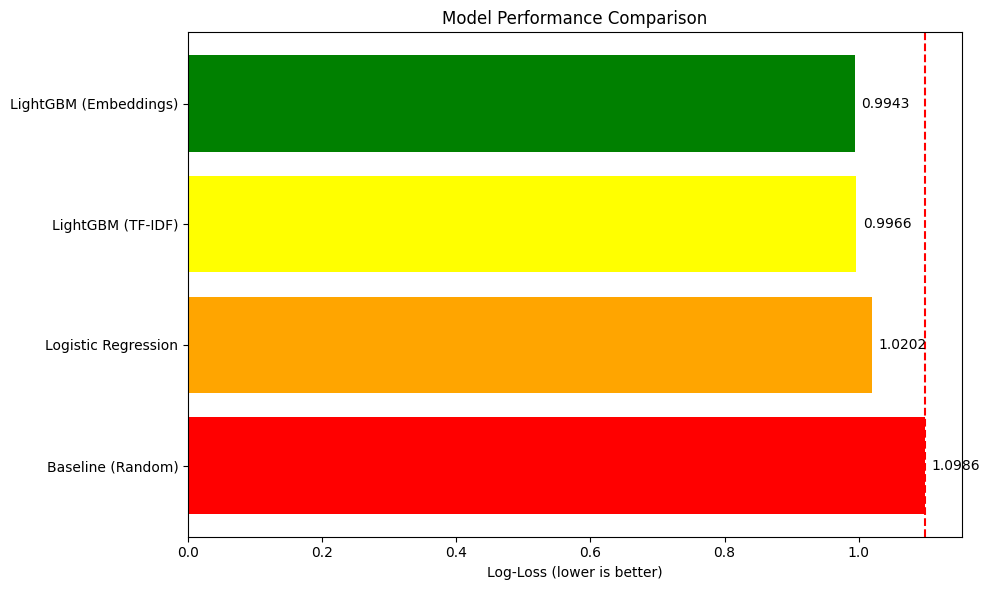

In [26]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Baseline (Random)', 'Logistic Regression', 'LightGBM (TF-IDF)', 'LightGBM (Embeddings)'],
    'Log-Loss': [baseline_logloss, test_logloss, test_logloss_lgb, test_logloss_emb],
    'Improvement': ['0%', 
                    f"{((baseline_logloss - test_logloss) / baseline_logloss * 100):.1f}%",
                    f"{((baseline_logloss - test_logloss_lgb) / baseline_logloss * 100):.1f}%",
                    f"{((baseline_logloss - test_logloss_emb) / baseline_logloss * 100):.1f}%"]
})

print(results.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
models = results['Model']
scores = results['Log-Loss']
colors = ['red', 'orange', 'yellow', 'green']

bars = ax.barh(models, scores, color=colors)
ax.set_xlabel('Log-Loss (lower is better)')
ax.set_title('Model Performance Comparison')
ax.axvline(x=baseline_logloss, color='red', linestyle='--', label='Baseline')

for i, (bar, score) in enumerate(zip(bars, scores)):
    ax.text(score + 0.01, i, f'{score:.4f}', va='center')

plt.tight_layout()
plt.show()

Confusion Matrix:
[[2418 1012  675]
 [ 985 2279  642]
 [1255 1125 1152]]

Classification Report:
              precision    recall  f1-score   support

Model A wins       0.52      0.59      0.55      4105
Model B wins       0.52      0.58      0.55      3906
         Tie       0.47      0.33      0.38      3532

    accuracy                           0.51     11543
   macro avg       0.50      0.50      0.49     11543
weighted avg       0.50      0.51      0.50     11543



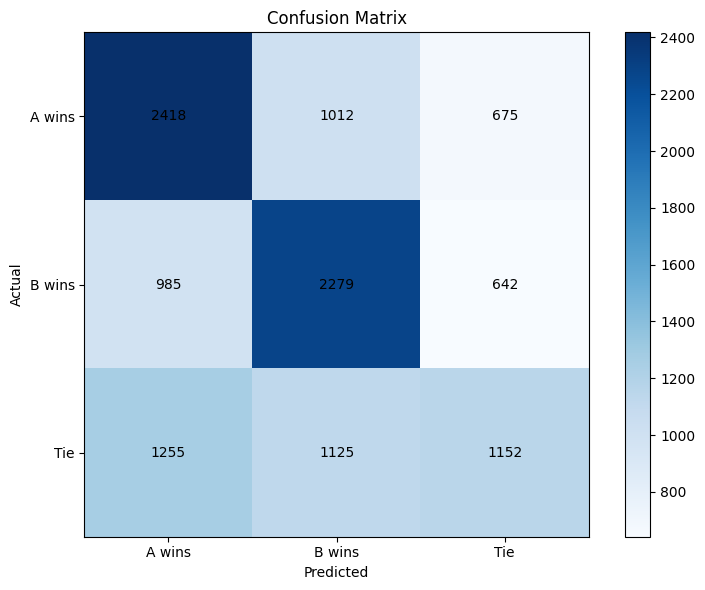

In [27]:
# Confusion matrix for best model
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf_lgb.predict(X_test_lgb)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Model A wins', 'Model B wins', 'Tie']))

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(['A wins', 'B wins', 'Tie'])
ax.set_yticklabels(['A wins', 'B wins', 'Tie'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Add text annotations
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [28]:
# Error analysis: where does the model struggle?
errors = y_test != y_pred
error_indices = np.where(errors)[0]

print(f"Total errors: {errors.sum()} out of {len(y_test)} ({errors.mean()*100:.1f}%)")
print(f"\nError breakdown by true class:")
for class_idx in [0, 1, 2]:
    class_mask = y_test == class_idx
    class_errors = errors[class_mask]
    class_name = ['Model A wins', 'Model B wins', 'Tie'][class_idx]
    print(f"{class_name}: {class_errors.sum()} errors out of {class_mask.sum()} ({class_errors.mean()*100:.1f}%)")

# Show some examples of errors
print("\nExample errors:")
for i in error_indices[:3]:
    true_class = ['A wins', 'B wins', 'Tie'][y_test[i]]
    pred_class = ['A wins', 'B wins', 'Tie'][y_pred[i]]
    print(f"\nTrue: {true_class}, Predicted: {pred_class}")
    print(f"Prompt: {test_df.iloc[i]['prompt'][:100]}...")
    print(f"Model A: {test_df.iloc[i]['model_a']}")
    print(f"Model B: {test_df.iloc[i]['model_b']}")

Total errors: 5694 out of 11543 (49.3%)

Error breakdown by true class:
Model A wins: 1687 errors out of 4105 (41.1%)
Model B wins: 1627 errors out of 3906 (41.7%)
Tie: 2380 errors out of 3532 (67.4%)

Example errors:

True: A wins, Predicted: B wins
Prompt: ["Can you create a caption using this, thanks? Gus noticed some Molly Fish looking uncomfortable in ...
Model A: chatglm3-6b
Model B: openchat-3.5

True: Tie, Predicted: B wins
Prompt: ["Can you explain what the Cypher Query Language is?"]...
Model A: llama2-70b-steerlm-chat
Model B: gpt-4-0125-preview

True: B wins, Predicted: A wins
Prompt: ["Are all countries obliged to not conduct nuclear weapons testing ","So it is legal to test nuclear...
Model A: claude-2.0
Model B: claude-2.1


## Summary and Conclusions

Results Analysis:
- Baseline (random guessing): 1.0986 log-loss
- Best model (LightGBM with embeddings): 0.9943 log-loss
- Overall improvement: 9.5% better than random
- Embeddings provided minimal improvement (0.2%) over TF-IDF

Key findings:
1. Model win rates are the strongest predictive features
2. Response length differences matter significantly  
3. The model struggles most with predicting ties (67% error rate)
4. Semantic embeddings did not provide substantial improvement

Recommendations for improvement:
1. Add more sophisticated features (response style, tone, politeness)
2. Try ensemble methods (combine multiple models)
3. Investigate why tie predictions are so difficult
4. Consider fine-tuning a transformer model for better semantic understanding